# Open-source review

## DARTS - sklearn for time series (улучшенный аналог sktime)

[DARTS](https://github.com/unit8co/darts)

* предоставляет унифицированный интерфейс для работы с временными рядам
* поддерживает этот интерфейс для **любых** типов алгоритмов, от классических до DL
* предоставляет богатый функционал для работы с дополнительными признаками
* имеет неплохой встроенный функционал для anomaly detection

## Nixtlaverse - time series ecosystem

[NIXTLA](https://nixtlaverse.nixtla.io)

* в противоположность DARTS, предоставляет по фреймворку для каждого конкретного типа моделей
* делает акцент на скорости работы
* имеет хорошую поддержку DL подходов к прогнозированию

## VARIMA - vector ARIMA

### В чем суть?

Расширение модели ARIMA на многомерный случай, т.е. когда необходимо прогнозировать сразу несколько компонент многомерного ряда и есть
предположение о скоррелированности компонент

$$\begin{bmatrix}y_{1,t} \\ y_{2,t}\end{bmatrix} = \begin{bmatrix}c_{1} \\ c_{2}\end{bmatrix} + \begin{bmatrix}a_{1,1}&a_{1,2} \\ a_{2,1}&a_{2,2}\end{bmatrix}\begin{bmatrix}y_{1,t-1} \\ y_{2,t-1}\end{bmatrix} + \begin{bmatrix}e_{1,t} \\ e_{2,t}\end{bmatrix}$$

### Когда использовать?

Когда есть необходимость использовать ARIMA для прогнозирования многомерных временных рядов с имеющимися кросс-корреляциями

### Пример

In [8]:
from darts.datasets import ETTh2Dataset
from darts.models import VARIMA
from darts.utils.timeseries_generation import holidays_timeseries
# forecasting the High UseFul Load ("HUFL") and Oil Temperature ("OT")
series = ETTh2Dataset().load()[:500][["HUFL", "OT"]]
# optionally, use some future covariates; e.g. encode each timestep whether it is on a holiday
future_cov = holidays_timeseries(series.time_index, "CN", add_length=6)
# no clear trend in the dataset
model = VARIMA(trend="n")
model.fit(series, future_covariates=future_cov)
pred = model.predict(6, future_covariates=future_cov)
# the two targets are predicted together
pred.values()

/Users/technogleb/ts_march_2024/.env/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/technogleb/ts_march_2024/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([[48.11853508, 47.94271279],
       [49.8532582 , 47.97710858],
       [51.16158614, 47.99800748],
       [52.1468715 , 48.00868317],
       [52.88741623, 48.01161583],
       [53.44254336, 48.00868452]])

<Axes: xlabel='date'>

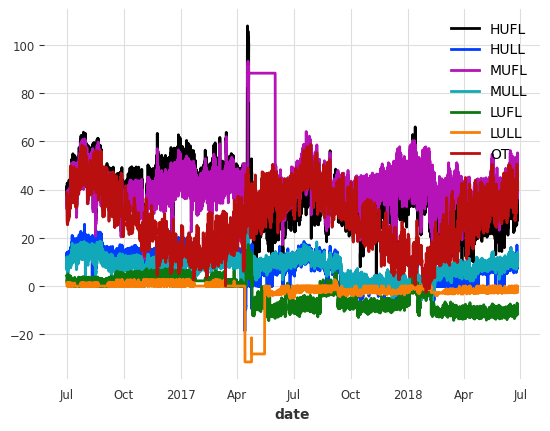

In [10]:
ETTh2Dataset().load().plot()

## AutoETS, AutoCES, AutoTheta

### Отступление: немного про экспоненциальное сглаживание

Простое экспоненциальное сглаживание
$$y_t = s_t = \alpha x_t + (1-\alpha) s_{t-1} $$

Двойное экспоненциальное сглаживание
$$
\begin{align}
y_t & = s_t + b_t\\ 
s_t & = \alpha x_t + (1-\alpha)(s_{t-1} + b_{t-1})\\
b_t & = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}\\
\end{align}
$$

### В чем суть?

Предоставляет модель экспоненциального сглаживания (как обычного, так и двойного, тройного, так и модели дрифта), и автоматически находит
оптимальные гиперпараметры моделей. Хорошо оптимизирована.

https://otexts.com/fpp2/expsmooth.html  
https://robjhyndman.com/papers/Theta.pdf

### Когда использовать?

Когда есть необходимость быстрого и удовлетворительного по качеству алгоритма массового прогнозирования.

### Пример

<Axes: xlabel='Month'>

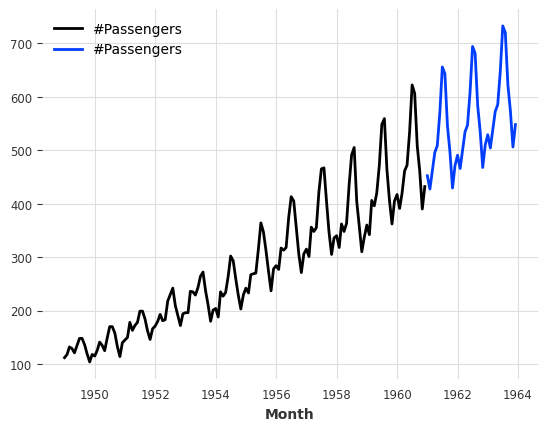

In [36]:
from darts.datasets import AirPassengersDataset
from darts.models import StatsForecastAutoETS
from darts.utils.timeseries_generation import datetime_attribute_timeseries
series = AirPassengersDataset().load()
# optionally, use some future covariates; e.g. the value of the month encoded as a sine and cosine series
future_cov = datetime_attribute_timeseries(series, "month", cyclic=True, add_length=36)
# define StatsForecastAutoETS parameters
model = StatsForecastAutoETS(season_length=12, model="AAA")
model.fit(series, future_covariates=future_cov)
pred = model.predict(36, future_covariates=future_cov)
series.plot()
pred.plot()

<Axes: xlabel='Month'>

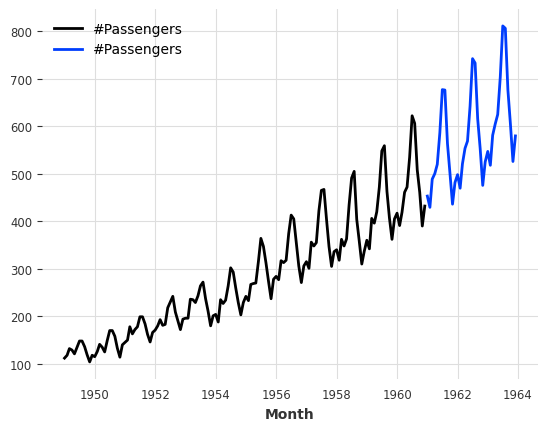

In [37]:
from darts.datasets import AirPassengersDataset
from darts.models import StatsForecastAutoCES
series = AirPassengersDataset().load()
# define StatsForecastAutoCES parameters
model = StatsForecastAutoCES(season_length=12, model="F")
model.fit(series)
pred = model.predict(36)
series.plot()
pred.plot()

<Axes: xlabel='Month'>

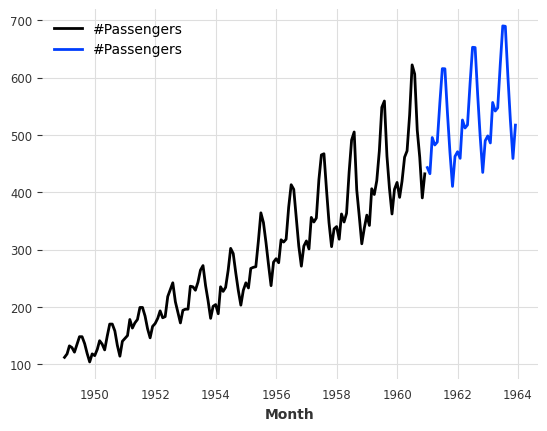

In [39]:
from darts.datasets import AirPassengersDataset
from darts.models import StatsForecastAutoTheta
series = AirPassengersDataset().load()
# define StatsForecastAutoTheta parameters
model = StatsForecastAutoTheta(season_length=12)
model.fit(series)
pred = model.predict(36)
series.plot()
pred.plot()

## TBATS

### В чем суть?

Статистический метод Роба Хиндмана, хорошо подходящий под моделирование рядов с мультипликативной сезонностью.

Временной ряд сначала проходит через преобразование Бокса-Кокса (логарифмирование в большинстве случаев),
затем сезонность моделируется через преобразование Фурье, а остатки через модель ARMA(p, q). 

https://robjhyndman.com/papers/ComplexSeasonality.pdf

### Когда использовать?

Для тех же сценариев, что и экспоненциальные сглаживания, но с лучшим качеством на сезонных рядах (и более медленной скоростью работы).

### Пример.

<Axes: xlabel='Month'>

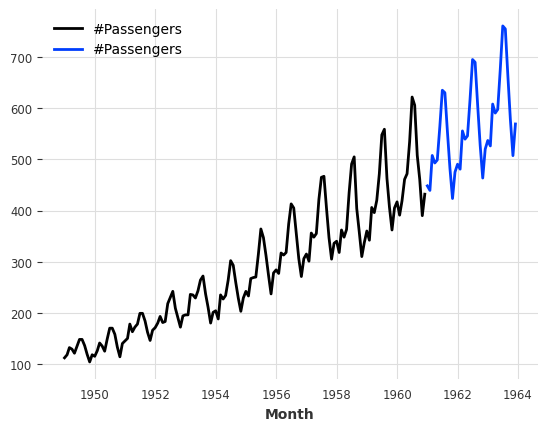

In [33]:
from darts.datasets import AirPassengersDataset
from darts.models import TBATS # or BATS
series = AirPassengersDataset().load()
# based on preliminary analysis, the series contains a trend
model = TBATS(use_trend=True)
model.fit(series)
pred = model.predict(36)
series.plot()
pred.plot()

## Prophet

### В чем суть?

Очень популярный метод прогнозирования от Facebook research. Представляет собой аддитивную модель, где тренд задается как кусочно-линейная функция, которая может изменяться в зависимости от определенных параметров, которые называются change points. Сезонность моделируется помощи преобразования Фурье и календаря праздников.
$$y(t) = T(t) + S(t) + H(t) + e(t)$$


https://peerj.com/preprints/3190.pdf

### Когда использовать?

Для задачи полу-автоматического прогнозирования рядов средних и длинных временных рядов с изменяющимся трендов и сложной сезонностью

## CalmanForecaster

### В чем суть?

Алгоритм прогнозирования на основе фильтра Калмана

https://habr.com/ru/companies/singularis/articles/516798/

### Когда использовать?

Когда есть необходимость массового прогнозирования крайне зашумленных рядов. 

### Пример

<Axes: xlabel='Month'>

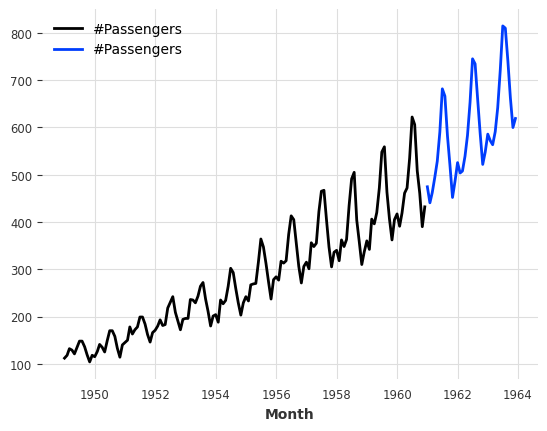

In [47]:
from darts.datasets import AirPassengersDataset
from darts.models import KalmanForecaster
from darts.utils.timeseries_generation import datetime_attribute_timeseries
series = AirPassengersDataset().load()
# optionally, use some future covariates; e.g. the value of the month encoded as a sine and cosine series
future_cov = datetime_attribute_timeseries(series, "month", cyclic=True, add_length=36)
# increasing the size of the state vector
model = KalmanForecaster(dim_x=12)
model.fit(series, future_covariates=future_cov)
pred = model.predict(36, future_covariates=future_cov)
series.plot()
pred.plot()